In [34]:
from pymongo import MongoClient
from pandas import DataFrame
import matplotlib as mpl
import matplotlib.ticker as mtick

In [35]:
# https://stackoverflow.com/questions/16259923/how-can-i-escape-latex-special-characters-inside-django-templates
import re

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

In [36]:
# https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width=422.52348, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

# Example 1

Get percentage of correctly parsed lines on line-level per parser

In [37]:
def get_correctly_parsed_ratio():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'fileMetrics_incomplete': False,
                }
            }, {
                '$group': {
                    '_id': {
                        'parser': '$parser',
                        'fileType': '$fileMetrics_fileType'
                    }, 
                    'correctlyParsedAvg': {
                        '$avg': {
                            '$ifNull': [
                                '$lineMetrics_correctlyParsed', 0
                            ]
                        }
                    }
                }
            }
        ])

In [38]:
def get_correctly_parsed_clean_ratio():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'fileMetrics_incomplete': False, 
                    'status': 'success'
                }
            }, {
                '$group': {
                    '_id': {
                        'parser': '$parser',
                        'fileType': '$fileMetrics_fileType'
                    }, 
                    'correctlyParsedCleanAvg': {
                        '$avg': '$lineMetrics_correctlyParsedClean'
                    }
                }
            }
        ])

In [39]:
query_result = zip(
    sorted(get_correctly_parsed_ratio(), key=lambda m: (m['_id']['parser'], m['_id']['fileType'])), 
    sorted(get_correctly_parsed_clean_ratio(), key=lambda m: (m['_id']['parser'], m['_id']['fileType']))
)
DataFrame([
    {
        'parser': correctly_parsed['_id']['parser'],
        'fileType': correctly_parsed['_id']['fileType'],
        'correct': round(correctly_parsed['correctlyParsedAvg'], 3),
        'correctClean': round(correctly_parsed_clean['correctlyParsedCleanAvg'], 3)
    }
    for correctly_parsed, correctly_parsed_clean in query_result
])

,parser,fileType,correct,correctClean
0,cleverCSV,complex_multi,0.602,0.612
1,cleverCSV,complex_single,0.811,0.833
2,cleverCSV,simple,0.879,0.901
3,hypoparsr,complex_multi,0.381,0.468
4,hypoparsr,complex_single,0.440,0.592
5,hypoparsr,simple,0.538,0.764
6,rfc4180,complex_multi,0.233,0.233
7,rfc4180,complex_single,0.549,0.564
8,rfc4180,simple,0.449,0.461
9,sniffer,complex_multi,0.384,0.596


# Experiment 2

Get correctly parsed ratio on table-level divided by table type per parser.

In [40]:
def get_correctly_parsed_per_table():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'fileMetrics_incomplete': False
                }
            }, {
                '$unwind': {
                    'path': '$tableMetrics_tables'
                }
            }, {
                '$group': {
                    '_id': {
                        'tableType': '$tableMetrics_tables.type', 
                        'parser': '$parser'
                    }, 
                    'correctlyParsedAvg': {
                        '$avg': {
                            '$ifNull': [
                                '$tableMetrics_tables.correctlyParsed', 0
                            ]
                        }
                    }
                }
            }
        ])

In [41]:
def get_correctly_parsed_clean_per_table():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'fileMetrics_incomplete': False,
                    'status': 'success'
                }
            }, {
                '$unwind': {
                    'path': '$tableMetrics_tables'
                }
            }, {
                '$group': {
                    '_id': {
                        'tableType': '$tableMetrics_tables.type', 
                        'parser': '$parser'
                    }, 
                    'correctlyParsedCleanAvg': {
                        '$avg': '$tableMetrics_tables.correctlyParsedClean'
                    }
                }
            }
        ])

In [42]:
query_result = zip(
    sorted(get_correctly_parsed_per_table(), key=lambda m: (m['_id']['parser'], m['_id']['tableType'])), 
    sorted(get_correctly_parsed_clean_per_table(), key=lambda m: (m['_id']['parser'], m['_id']['tableType']))
)
DataFrame([
    {
        'parser': correctly_parsed['_id']['parser'],
        'tableType': correctly_parsed['_id']['tableType'],
        'correct': round(correctly_parsed['correctlyParsedAvg'], 3),
        'correctClean': round(correctly_parsed_clean['correctlyParsedCleanAvg'], 3)
    }
    for correctly_parsed, correctly_parsed_clean in query_result
]).sort_values(by=['tableType', 'parser'])

,parser,tableType,correct,correctClean
0,cleverCSV,character,0.914,0.932
2,hypoparsr,character,0.577,0.733
4,rfc4180,character,0.465,0.478
6,sniffer,character,0.821,0.903
8,structureBased,character,0.741,0.815
10,tableExtractor,character,0.792,0.895
1,cleverCSV,layout,0.127,0.130
3,hypoparsr,layout,0.066,0.106
5,rfc4180,layout,0.004,0.004
7,sniffer,layout,0.066,0.103


# Experiment 3

Compare number of files that have been parsed correctly with X percent across parsers

In [43]:
def get_ratio_per_table(parser):
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'parser': parser, 
                    'fileMetrics_incomplete': False, 
                    'status': 'success'
                }
            }, {
                '$unwind': {
                    'path': '$tableMetrics_tables'
                }
            }, {
                '$project': {
                    'tableMetrics_tables.correctlyParsedClean': True,
                    'fileId': True,
                    '_id': False
                }
            }
        ])

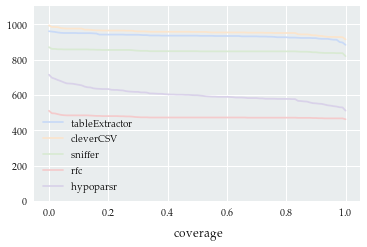

In [44]:
tableExtractorCoverage = [*get_ratio_per_table('tableExtractor')]
cleverCSVCoverage = [*get_ratio_per_table('cleverCSV')]
snifferCoverage = [*get_ratio_per_table('sniffer')]
hypoparsrCoverage = [*get_ratio_per_table('hypoparsr')]
rfcCoverage = [*get_ratio_per_table('rfc4180')]

DataFrame([
    {
        'coverage': coverage_level,
        'tableExtractor': sum(coverage['tableMetrics_tables']['correctlyParsedClean'] >= coverage_level for coverage in tableExtractorCoverage if coverage['tableMetrics_tables']['correctlyParsedClean']),
        'cleverCSV': sum(coverage['tableMetrics_tables']['correctlyParsedClean'] >= coverage_level for coverage in cleverCSVCoverage if coverage['tableMetrics_tables']['correctlyParsedClean']),
        'sniffer': sum(coverage['tableMetrics_tables']['correctlyParsedClean'] >= coverage_level for coverage in snifferCoverage if coverage['tableMetrics_tables']['correctlyParsedClean']),
        'rfc': sum(coverage['tableMetrics_tables']['correctlyParsedClean'] >= coverage_level for coverage in rfcCoverage if coverage['tableMetrics_tables']['correctlyParsedClean']),
        'hypoparsr': sum(coverage['tableMetrics_tables']['correctlyParsedClean'] >= coverage_level for coverage in hypoparsrCoverage if coverage['tableMetrics_tables']['correctlyParsedClean']),
    }
    for coverage_level in (round(v * 0.01, 2) for v in range(100, -1, -1))
]).plot(x='coverage', ylim=(0, 1100))

# Experiment 4

Show percentages of clean parsed lines grouped by file type per parser

In [64]:
def get_correctly_parsed_clean_by_file_type():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'fileMetrics_incomplete': False,
                    'status': 'success'
                }
            }, {
                '$group': {
                    '_id': '$fileMetrics_fileType',
                    'RFC 4180': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'rfc4180'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    },
                    'Hypoparsr': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'hypoparsr'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    },
                    'Sniffer': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'sniffer'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    }, 
                    'CleverCSV': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'cleverCSV'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    },
                    'ExtracTable': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'tableExtractor'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    }, 
                }
            }
        ])

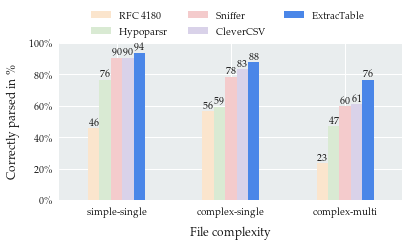

In [65]:
file_complexity_dict = {
    'simple': 'simple-single',
    'complex_single': 'complex-single',
    'complex_multi': 'complex-multi'
}
df = DataFrame(
    {
        **member,
        '_id': file_complexity_dict[member['_id']]
    }
    for member in get_correctly_parsed_clean_by_file_type()
).sort_values(
    by='_id', 
    ascending=False
)

ax = df.plot(
    kind='bar', 
    x='_id',
    rot=0,
    color=['#FBE5CD','#D9EAD3','#F4CBCC', '#D9D2E9', '#4A86E8'],
#     edgecolor='#595959'
)

ax.set(
    xlabel='File complexity',
    ylabel='Correctly parsed in \%',
    ylim=(0, 1)
)

for p in ax.patches:
    ax.annotate(
        round(p.get_height() * 100),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',                              
        va='center',                              
        xytext=(0, 5),                               
        textcoords='offset points',
        fontsize=10
    )

ax.get_yaxis().set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend(loc='lower center', bbox_to_anchor=(0, 0.98, 0.98, 0), ncol=3)

plt.tight_layout()
ax.get_figure().savefig('correctly-parsed-per-file-type')

# Example 5

Show average ratio of correctly parsed tables (clean) by table type per parser

In [79]:
def get_correctly_parsed_clean_by_table_type():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'fileMetrics_incomplete': False,
                    'status': 'success'
                }
            }, {
                '$unwind': {
                    'path': '$tableMetrics_tables'
                }
            }, {
                '$group': {
                    '_id': '$tableMetrics_tables.type', 
                    'RFC 4180': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'rfc4180'
                                    ]
                                }, '$tableMetrics_tables.correctlyParsedClean', None
                            ]
                        }
                    },                     
                    'Hypoparsr': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'hypoparsr'
                                    ]
                                }, '$tableMetrics_tables.correctlyParsedClean', None
                            ]
                        }
                    },
                    'Structure-based': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'structureBased'
                                    ]
                                }, '$tableMetrics_tables.correctlyParsedClean', None
                            ]
                        }
                    },
                    'Sniffer': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'sniffer'
                                    ]
                                }, '$tableMetrics_tables.correctlyParsedClean', None
                            ]
                        }
                    },
                    'CleverCSV': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'cleverCSV'
                                    ]
                                }, '$tableMetrics_tables.correctlyParsedClean', None
                            ]
                        }
                    },
                    'ExtracTable': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'tableExtractor'
                                    ]
                                }, '$tableMetrics_tables.correctlyParsedClean', None
                            ]
                        }
                    },
                }
            }
        ])

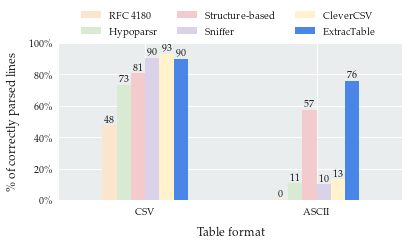

In [85]:
df = DataFrame(
    [
        {
            **group,
            '_id': 'CSV' if group['_id'] == 'character' else 'ASCII'
        }
        for group in get_correctly_parsed_clean_by_table_type()
    ]
).set_index(
    '_id'
).sort_values(
    by='_id',
    ascending=False
)

ax = df.plot(
    kind='bar', 
    rot=0,
#     color=['#595959','#595959','#595959', '#595959', '#595959']
    color=['#FBE5CD','#D9EAD3','#F4CBCC', '#D9D2E9', '#FFF2CC', '#4A86E8'],
#     edgecolor='#595959'
)

ax.set(
    xlabel='Table format',
    ylabel='\% of correctly parsed lines',
    ylim=(0, 1)
)

# hatches = ['--', '--', '//', '//', 'xx', 'xx', '\\\\', '\\\\']
for p in ax.patches:
    ax.annotate(
        round(p.get_height() * 100),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',                              
        va='center',                              
        xytext=(0, 5),                               
        textcoords='offset points',
        fontsize=10
    )
#     p.set_hatch(hatch)
#     if not (hatch is None):
#         p.set_edgecolor('#FFFFFF')

ax.get_yaxis().set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend(loc='lower center', bbox_to_anchor=(0, 0.98, 0.98, 0), ncol=3)

plt.tight_layout()
ax.get_figure().savefig('correctly-parsed-per-table-format')

In [69]:
df.head()

,RFC 4180,Hypoparsr,StructureBased,Sniffer,CleverCSV,ExtracTable
_id,,,,,,
CSV,0.477606,0.733430,0.810723,0.903291,0.932140,0.895407
ASCII,0.003742,0.105631,0.572365,0.102986,0.130492,0.756109


# Experiment 6
Disabled data type recognition comparison

In [50]:
def get_parsed_clean_line_level(collection):
    with MongoClient() as mongo:
        db = mongo['master']
        return db[collection].aggregate([
            {
                '$match': {
                    'fileMetrics_incomplete': False, 
                    'status': 'success', 
                    'parser': 'tableExtractor'
                }
            }, {
                '$group': {
                    '_id': None, 
                    'average': {
                        '$avg': '$lineMetrics_correctlyParsedClean'
                    }
                }
            }
        ])

In [51]:
print('Parsed clean DT enabled', next(get_parsed_clean_line_level('metrics'))['average'])
print('Parsed clean DT disabled', next(get_parsed_clean_line_level('metrics_dt_disabled'))['average'])

Parsed clean DT enabled 0.9054506249479448
Parsed clean DT disabled 0.7831160549507709


# Experiment 7

Numbers by source

In [52]:
def get_correctly_parsed_clean_by_source():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['files'].aggregate([
            {
                '$match': {
                    'incomplete': {
                        '$exists': False
                    }
                }
            }, {
                '$lookup': {
                    'from': 'metrics', 
                    'let': {
                        'fileId': {
                            '$toString': '$_id'
                        }
                    }, 
                    'pipeline': [
                        {
                            '$match': {
                                '$expr': {
                                    '$eq': [
                                        '$fileId', '$$fileId'
                                    ]
                                }
                            }
                        }
                    ], 
                    'as': 'metrics'
                }
            }, {
                '$unwind': {
                    'path': '$metrics'
                }
            }, {
                '$unwind': {
                    'path': '$metrics.tableMetrics_tables'
                }
            }, {
                '$project': {
                    'parser': '$metrics.parser', 
                    'lineMetrics_correctlyParsedClean': '$metrics.lineMetrics_correctlyParsedClean', 
                    'status': '$metrics.status', 
                    'source': True
                }
            }, {
                '$match': {
                    'status': 'success'
                }
            }, {
                '$group': {
                    '_id': '$source', 
                    'RFC 4180': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'rfc4180'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    }, 
                    'Hypoparsr': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'hypoparsr'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    }, 
                    'Sniffer': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'sniffer'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    }, 
                    'CleverCSV': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'cleverCSV'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    }, 
                    'ExtracTable': {
                        '$avg': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$parser', 'tableExtractor'
                                    ]
                                }, '$lineMetrics_correctlyParsedClean', None
                            ]
                        }
                    }
                }
            }
        ])

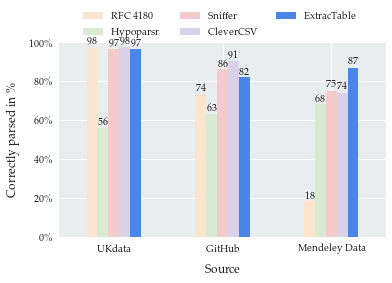

In [53]:
source_map = { 'ukdata': "UKdata", 'github': 'GitHub', 'mendeley': 'Mendeley Data'}
sort_source = {'UKdata': 0, 'GitHub': 1, 'Mendeley Data': 2}
df = DataFrame(
    [
        {
            **group,
            '_id': source_map[group['_id']]
        }
        for group in get_correctly_parsed_clean_by_source()
    ]
).sort_values(
    by='_id', 
    key=lambda source: source.map(sort_source),
    ascending=True
).set_index(
    '_id'
)

ax = df.plot(
    kind='bar', 
    rot=0,
    color=['#FBE5CD','#D9EAD3','#F4CBCC', '#D9D2E9', '#4A86E8'],
#     edgecolor='#595959'
)

ax.set(
    xlabel='Source',
    ylabel='Correctly parsed in \%',
    ylim=(0, 1)
)

for p in ax.patches:
    ax.annotate(
        round(p.get_height() * 100),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',                              
        va='center',                              
        xytext=(0, 5),                               
        textcoords='offset points',
        fontsize=10
    )

ax.get_yaxis().set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend(loc='lower center', bbox_to_anchor=(0, 0.98, 0.98, 0), ncol=3)

# Experiment 8

Distribution correctly parsed per table type

In [54]:
def get_correctly_parsed(table_type):
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$unwind': {
                    'path': '$tableMetrics_tables'
                }
            }, {
                '$match': {
                    'parser': 'tableExtractor', 
                    'status': 'success', 
                    'fileMetrics_incomplete': False, 
                    'tableMetrics_tables.type': table_type
                }
            }, {
                '$project': {
                    'correctlyParsedClean': '$tableMetrics_tables.correctlyParsedClean'
                }
            }
        ])

In [55]:
df.head()

,RFC 4180,Hypoparsr,Sniffer,CleverCSV,ExtracTable
_id,,,,,
UKdata,0.975821,0.561807,0.965512,0.975729,0.965254
GitHub,0.735613,0.634424,0.861958,0.905166,0.821384
Mendeley Data,0.182263,0.682051,0.751708,0.741162,0.870876


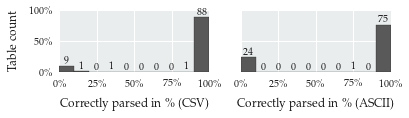

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=set_size(subplots=(1, 2)), sharey=True)

df = DataFrame(get_correctly_parsed('character'))
ax = df.plot(
    kind='hist',
    ax=axes[0], 
    legend=False,
    density=True,
    color=['#595959'],
    edgecolor='#1B1B1B'
)

ax.set(
    ylim=(0, 10),
    xlim=(0, 1),
    ylabel='Table count',
    xlabel='Correctly parsed in \% (CSV)',
#     yscale='log'
)

ax.get_yaxis().set_major_formatter(mtick.PercentFormatter(xmax=10))
ax.get_xaxis().set_major_formatter(mtick.PercentFormatter(xmax=1))


for p in ax.patches:
    ax.annotate(
        round(p.get_height() * 10),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',                              
        va='center',                              
        xytext=(0, 5),                               
        textcoords='offset points',
        fontsize=10
    )


df = DataFrame(get_correctly_parsed('layout'))
ax = df.plot(
    kind='hist', 
    ax=axes[1], 
    legend=False,
    density=True,
    color=['#595959'],
    edgecolor='#1B1B1B'
)

for p in ax.patches:
    ax.annotate(
        round(p.get_height() * 10),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',                              
        va='center',                              
        xytext=(0, 5),                               
        textcoords='offset points',
        fontsize=10
    )

ax.set(
    xlim=(0, 1),
    xlabel='Correctly parsed in \% (ASCII)'
)

ax.get_xaxis().set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.tight_layout()
ax.get_figure().savefig('correctly-parsed-distributions')

# Showcase 1

What files have been successfully processed by tableExtractor, but had tables in them that have been parsed incorrectly (0%). 

In [57]:
set(
    coverage['fileId']
    for coverage in tableExtractorCoverage
    if not coverage['tableMetrics_tables']['correctlyParsedClean']
)

{'5fa19c250c27781bd85c52ac',
 '5fa19c250c27781bd85c5483',
 '5fa19c510c27781bd869186c',
 '5fa19cbd0c27781bd88a6249',
 '5fa19d6e0c27781bd8c23efa',
 '5fa19d7a0c27781bd8c6b1d4',
 '5fa19e880c27781bd81fc897',
 '5fa19f2f0c27781bd856b981',
 '5fa1a3ba0c27781bd8ee6e2d',
 '5fa1a3ba0c27781bd8ee6e72',
 '5fa1a3c30c27781bd8f0fd4a',
 '5fa1a67d0c27781bd8e736ce',
 '5fa1a91b0c27781bd8f6cb1d',
 '5fa1aa2a0c27781bd85559a8',
 '5fa1abef0c27781bd8f73a43',
 '5fa1bb76b543bb088d317026',
 '5fa1bb9db543bb088d39ca0e',
 '5fa1bba4b543bb088d3a6b87',
 '5fa1bbb7b543bb088d3f2503',
 '5fa1bca4b543bb088d7b2d6f',
 '5fa1bfaab543bb088d6b03c2',
 '5fa1c167b543bb088dc9d7a1',
 '5fa1c347b543bb088d499854',
 '5fa1c3f7b543bb088d849040',
 '5fa1c5d0b543bb088d181254',
 '5fa1c606b543bb088d2a621e',
 '5fa1c60bb543bb088d2b72bf',
 '5fa1c66bb543bb088d4cdd3a',
 '5fa1c7bcb543bb088dc1d5d9',
 '5fa1c7bdb543bb088dc211e8',
 '5fa1c7c1b543bb088dc3422d',
 '5fa1c7c1b543bb088dc3454c',
 '5fa1c7c9b543bb088dc55830',
 '5fa1d5de6fea3636860f2013',
 '5fa1db0f6fea

- inconspicuous
    - 5fa19c250c27781bd85c52ac
    - 5fa19c250c27781bd85c5483
- matrix, with weird values like "3, " or "0,+", which is not consistent
    - 5fa19c4a0c27781bd866ba46
    - 5fa19c4a0c27781bd866bac1
- sparse data
    - 5fa19c930c27781bd87bd885
    - 5fa1bca3b543bb088d7b16ed
- additional empty column
    - 5fa1a67d0c27781bd8e736ce
- ASCII, splitting column too much
    - 5fa1abef0c27781bd8f73a43
    - 5fa1bb9db543bb088d39ca0e
    - 5fa1bbb7b543bb088d3f2503
    - 5fa1bfaab543bb088d6b03c2
    - 5fa1c3f7b543bb088d849040
    - 5fa1c485b543bb088dad1693
    - 5fa1c7bcb543bb088dc1d5d9
    - 5fa1db0f6fea363686d417db
- ASCII, not splitting enough
    - 5fa1bba4b543bb088d3a6b87
- ASCII, mixing two tables
    - 5fa1c60bb543bb088d2b72bf
    - 5fa1c7c9b543bb088dc55830
- Ambiguous
    - 5fa1bca5b543bb088d7b6151
    - 5fa1c7bdb543bb088dc211e8 (solution with . as delimiter produces more columns, which we favor)
- Border elements still present
    - 5fa1c167b543bb088dc9d7a1
- no problem detected
    - 5fa1ce3d6fea3636868ddcdc
    - 5fa1ce506fea3636869228c2
    - 5fa1d58b6fea363686fafe3e
- simply wrong
    - 5fa1ce3d6fea3636868ddcdc

CSV
    - 5fa19c510c27781bd869186c: sacrifice correct dialect to capture (wrong) header (still yielding good pattern)
    - 5fa19c250c27781bd85c52ac: just wrong, always the same string repeating causing same number of white spaces
    - 5fa1bb76b543bb088d317026: ASCII instead of tab
    - ambigous cases: we also accepted solution 5fa1bb9db543bb088d39ca0e (stacked tables, that could be interpreted as whole by ASCII but we annotated as multiple tables and tab)

Last file, that we have looked at: 5fa1db0f6fea363686d417db